In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # Technical analysis library
import time
from datetime import datetime, timedelta
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_sp500_tickers():
    """Get S&P 500 tickers from Wikipedia"""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    return sp500_table['Symbol'].tolist()
sp500_tickers = get_sp500_tickers()
print(f"S&P 500 tickers: {len(sp500_tickers)}")

S&P 500 tickers: 503


In [4]:
data = yf.download(sp500_tickers, period='5y', interval='1d')

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


Price      Adj Close            Close                                         \
Ticker          BF.B BRK.B          A        AAPL       ABBV ABNB        ABT   
Date                                                                           
2020-08-12       NaN   NaN  94.387802  110.051605  78.096283  NaN  92.059998   
2020-08-13       NaN   NaN  95.489929  111.999229  77.417610  NaN  92.471581   
2020-08-14       NaN   NaN  94.136429  111.899414  77.736496  NaN  91.456322   
2020-08-17       NaN   NaN  94.271797  111.607262  78.783119  NaN  92.114868   
2020-08-18       NaN   NaN  94.610168  112.537277  78.210747  NaN  92.343529   

Price                                          ...   Volume                    \
Ticker           ACGL         ACN        ADBE  ...       WY     WYNN      XEL   
Date                                           ...                              
2020-08-12  30.999290  213.014877  445.359985  ...  2876600  6416400  2014400   
2020-08-13  30.771076  214.850647  450.019989  ...  3021800  3263400  1475000   
2020-08-14  30.666477  213.478439  447.600006  ...  3547700  2697100  3421100   
2020-08-17  30.200537  215.675812  451.579987  ...  4833500  2219900  2141800   
2020-08-18  30.029375  217.168549  463.510010  ...  3023000  2462300  1561400   

Price                                                                     
Ticker           XOM     XYL       XYZ      YUM     ZBH    ZBRA      ZTS  
Date                                                                      
2020-08-12  22503200  887100  10596900  1189300  843570  239600  1386500  
2020-08-13  17338700  510800   9835000  1221200  657552  142800  1192600  
2020-08-14  13595700  406100   6654700   781000  651887  163800  1780200  
2020-08-17  15554600  459000  13280500  1199200  761788  214800  2368000  
2020-08-18  13014000  464600   8523400  1463300  702048  317300  1476700  

[5 rows x 2517 columns]

In [5]:
class TechnicalIndicators:
    """
    A class to calculate various technical indicators for stock price data
    """
    
    @staticmethod
    def moving_average(data: pd.Series, window: int) -> pd.Series:
        """Calculate Simple Moving Average"""
        return data.rolling(window=window).mean()
    
    @staticmethod
    def exponential_moving_average(data: pd.Series, window: int) -> pd.Series:
        """Calculate Exponential Moving Average"""
        return data.ewm(span=window).mean()
    
    @staticmethod
    def returns(data: pd.Series, periods: int = 1) -> pd.Series:
        """Calculate returns over specified periods"""
        return data.pct_change(periods=periods)
    
    @staticmethod
    def future_returns(data: pd.Series, periods: int = 1) -> pd.Series:
        """Calculate future returns over specified periods"""
        return (data.shift(periods=periods) - data) / data

    @staticmethod
    def volatility(data: pd.Series, window: int) -> pd.Series:
        """Calculate rolling volatility (standard deviation of returns)"""
        returns = data.pct_change()
        return returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
    
    @staticmethod
    def rsi(data: pd.Series, window: int = 14) -> pd.Series:
        """Calculate Relative Strength Index"""
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    @staticmethod
    def macd(data: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9) -> Dict[str, pd.Series]:
        """Calculate MACD (Moving Average Convergence Divergence)"""
        ema_fast = data.ewm(span=fast).mean()
        ema_slow = data.ewm(span=slow).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal).mean()
        histogram = macd_line - signal_line
        
        return {
            'MACD': macd_line,
            'MACD_Signal': signal_line,
            'MACD_Histogram': histogram
        }
    
    @staticmethod
    def bollinger_bands(data: pd.Series, window: int = 20, num_std: float = 2) -> Dict[str, pd.Series]:
        """Calculate Bollinger Bands"""
        sma = data.rolling(window=window).mean()
        std = data.rolling(window=window).std()
        
        return {
            'BB_Upper': sma + (std * num_std),
            'BB_Middle': sma,
            'BB_Lower': sma - (std * num_std),
            'BB_Width': (sma + (std * num_std)) - (sma - (std * num_std)),
            'BB_Position': (data - sma) / (std * num_std)
        }
    
    @staticmethod
    def average_true_range(high: pd.Series, low: pd.Series, close: pd.Series, window: int = 14) -> pd.Series:
        """Calculate Average True Range"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())
        
        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        atr = true_range.rolling(window=window).mean()
        return atr
    
    @staticmethod
    def stochastic_oscillator(high: pd.Series, low: pd.Series, close: pd.Series, 
                            k_window: int = 14, d_window: int = 3) -> Dict[str, pd.Series]:
        """Calculate Stochastic Oscillator"""
        lowest_low = low.rolling(window=k_window).min()
        highest_high = high.rolling(window=k_window).max()
        
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=d_window).mean()
        
        return {
            'Stoch_K': k_percent,
            'Stoch_D': d_percent
        }




In [6]:
def calculate_all_indicators(stock_data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Calculate all technical indicators for all stocks
    """
    all_indicators = []
    
    print("Calculating technical indicators...")
    
    for ticker in stock_data.columns.get_level_values(1).unique().tolist():
        try:
            # Basic price data
            close = stock_data.loc[:, ('Close', ticker)]
            high = stock_data.loc[:,('High', ticker)]
            low = stock_data.loc[:, ('Low', ticker)]
            volume = stock_data.loc[:, ('Volume', ticker)]
            
            # Create a DataFrame for this stock's indicators
            indicators_df = pd.DataFrame(index=data.index)
            indicators_df['Ticker'] = ticker
            indicators_df['Close'] = close
            indicators_df['High'] = high
            indicators_df['Low'] = low
            indicators_df['Volume'] = volume
            

            # Future Returns
            for period in [-1, -5, -10, -21, -63]:
                indicators_df[f'Future_Return_{abs(period)}d'] = TechnicalIndicators.future_returns(close, period)

            # Moving Averages
            for window in [5, 10, 20, 50, 100, 200]:
                indicators_df[f'SMA_{window}'] = TechnicalIndicators.moving_average(close, window)
                indicators_df[f'EMA_{window}'] = TechnicalIndicators.exponential_moving_average(close, window)
            
            # Returns
            for period in [1, 5, 10, 21, 63]:
                indicators_df[f'Return_{period}d'] = TechnicalIndicators.returns(close, period)

            # Volatility
            for window in [10, 21, 63]:
                indicators_df[f'Volatility_{window}d'] = TechnicalIndicators.volatility(close, window)
            
            # RSI
            indicators_df['RSI_14'] = TechnicalIndicators.rsi(close, 14)
            indicators_df['RSI_21'] = TechnicalIndicators.rsi(close, 21)
            
            # MACD
            macd_data = TechnicalIndicators.macd(close)
            for key, value in macd_data.items():
                indicators_df[key] = value
            
            # Bollinger Bands
            bb_data = TechnicalIndicators.bollinger_bands(close)
            for key, value in bb_data.items():
                indicators_df[key] = value
            
            # ATR
            indicators_df['ATR_14'] = TechnicalIndicators.average_true_range(high, low, close, 14)
            
            # Stochastic Oscillator
            stoch_data = TechnicalIndicators.stochastic_oscillator(high, low, close)
            for key, value in stoch_data.items():
                indicators_df[key] = value
            
            # Volume indicators
            indicators_df['Volume_SMA_20'] = TechnicalIndicators.moving_average(volume, 20)
            indicators_df['Volume_Ratio'] = volume / indicators_df['Volume_SMA_20']
            
            # Price momentum
            indicators_df['Momentum_10'] = close / close.shift(10) - 1
            indicators_df['Momentum_21'] = close / close.shift(21) - 1
            
            # Price position relative to moving averages
            indicators_df['Price_vs_SMA20'] = close / indicators_df['SMA_20'] - 1
            indicators_df['Price_vs_SMA50'] = close / indicators_df['SMA_50'] - 1
            
            all_indicators.append(indicators_df)
            print(f"✓ Calculated indicators for {ticker}")
            
        except Exception as e:
            print(f"✗ Error calculating indicators for {ticker}: {str(e)}")
    
    # Combine all data
    if all_indicators:
        combined_df = pd.concat(all_indicators, ignore_index=False)
        combined_df.reset_index(inplace=True)
        combined_df.rename(columns={'index': 'Date'}, inplace=True)
        
        # Set MultiIndex
        combined_df.set_index(['Date', 'Ticker'], inplace=True)
        
        print(f"\nFinal dataset shape: {combined_df.shape}")
        print(f"Columns: {list(combined_df.columns)}")
        
        return combined_df
    else:
        print("No data to combine!")
        return pd.DataFrame()



In [7]:
stock_data = data.loc[:,(slice(None), sp500_tickers)]
dataframe = calculate_all_indicators(stock_data)

Calculating technical indicators...
✓ Calculated indicators for MMM
✓ Calculated indicators for AOS
✓ Calculated indicators for ABT
✓ Calculated indicators for ABBV
✓ Calculated indicators for ACN
✓ Calculated indicators for ADBE
✓ Calculated indicators for AMD
✓ Calculated indicators for AES
✓ Calculated indicators for AFL
✓ Calculated indicators for A
✓ Calculated indicators for APD
✓ Calculated indicators for ABNB
✓ Calculated indicators for AKAM
✓ Calculated indicators for ALB
✓ Calculated indicators for ARE
✓ Calculated indicators for ALGN
✓ Calculated indicators for ALLE
✓ Calculated indicators for LNT
✓ Calculated indicators for ALL
✓ Calculated indicators for GOOGL
✓ Calculated indicators for GOOG
✓ Calculated indicators for MO
✓ Calculated indicators for AMZN
✓ Calculated indicators for AMCR
✓ Calculated indicators for AEE
✓ Calculated indicators for AEP
✓ Calculated indicators for AXP
✓ Calculated indicators for AIG
✓ Calculated indicators for AMT
✓ Calculated indicators for 

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # or accuracy_score for classification

idx = pd.IndexSlice
first_date = min(dataframe.index.get_level_values('Date')) + pd.Timedelta(days=200)
last_date = max(dataframe.index.get_level_values('Date')) - pd.Timedelta(days=35)
df = dataframe.loc[idx[:, dataframe.index.get_level_values('Date') >= first_date], :]
df = df.loc[idx[:, df.index.get_level_values('Date') < last_date], :]
df = df.dropna()

split_date = '2024-05-01'
train = df.loc[idx[:, df.index.get_level_values('Date') < split_date], :]
test = df.loc[idx[:, df.index.get_level_values('Date') >= split_date], :]

X_train = train.drop(['Future_Return_1d', 'Future_Return_5d', 'Future_Return_10d', 'Future_Return_21d', 'Future_Return_63d'], axis=1)
y_train = train['Future_Return_21d']
X_test = test.drop(['Future_Return_1d', 'Future_Return_5d', 'Future_Return_10d', 'Future_Return_21d', 'Future_Return_63d'], axis=1)
y_test = test['Future_Return_21d']

# model = xgb.XGBRegressor()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [11]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
def random_search_tuning_ts(X, y, n_iter=50, n_splits=5):
    """
    Random search for XGBoost hyperparameters with Time Series CV
    """
    print("\n=== RANDOM SEARCH TUNING (Time Series) ===")
    
    # Define parameter distributions
    param_distributions = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    }
    
    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=tscv,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X, y)
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {-random_search.best_score_:.4f}")
    
    return random_search.best_estimator_, random_search.best_params_

In [ ]:

random_search_tuning_ts(X_train, y_train_week, n_iter=20, n_splits=5
                        )


=== RANDOM SEARCH TUNING (Time Series) ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'colsample_bytree': 0.7159005811655073, 'learning_rate': 0.058366386176201324, 'max_depth': 4, 'n_estimators': 219, 'reg_alpha': 0.808120379564417, 'reg_lambda': 0.6334037565104235, 'subsample': 0.9485842360750871}
Best CV score: 0.0021


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7159005811655073, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.058366386176201324,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=219, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...),
 {'colsample_bytree': 0.7159005811655073,
  'learning_rate': 0.058366386176201324,
  'max_depth': 4,
  'n_estimators': 219,
  'reg_alpha': 0.808120379564417,
  'reg_lambda': 0.6334037565104235,
  'subsample': 0.9485842360750

In [ ]:
params = {'colsample_bytree': 0.7159005811655073, 'learning_rate': 0.058366386176201324, 'max_depth': 4, 'n_estimators': 219, 'reg_alpha': 0.808120379564417, 'reg_lambda': 0.6334037565104235, 'subsample': 0.9485842360750871}

features = ['Price_vs_SMA50', 'Return_63d', 'RSI_21', 'MACD_Histogram', 'Return_5d', 'SMA_200', 'SMA_100']
X_train_simp = X_train[features]
X_test_simp = X_test[features]
y_train_week = train['Future_Return_5d']
y_test_week = test['Future_Return_5d']

model_weekly = xgb.XGBRegressor(**params)
model_weekly.fit(X_train_simp, y_train_week)
y_pred_week = model_weekly.predict(X_test_simp)

In [46]:
date = '2024-05-14'
ticker = 'GL'
data.loc[date, ('Open', ticker)]

83.32448139017562

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(data.index, data[('Close', ticker)], color='blue', label='Close Price')
ax1.set_ylabel('Close Price', color='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(data.index, data[('RSI', 'AAPL')], color='red', label='RSI (14)')
ax2.set_ylabel('RSI', color='red')
ax2.axhline(70, color='gray', linestyle='--', linewidth=1)
ax2.axhline(30, color='gray', linestyle='--', linewidth=1)
ax2.legend(loc='upper right')

plt.title('AAPL Close Price and RSI')
plt.show()

In [29]:
import pickle

# Save model
with open('xgb_model_simp.pkl', 'wb') as f:
    pickle.dump(model_weekly, f)

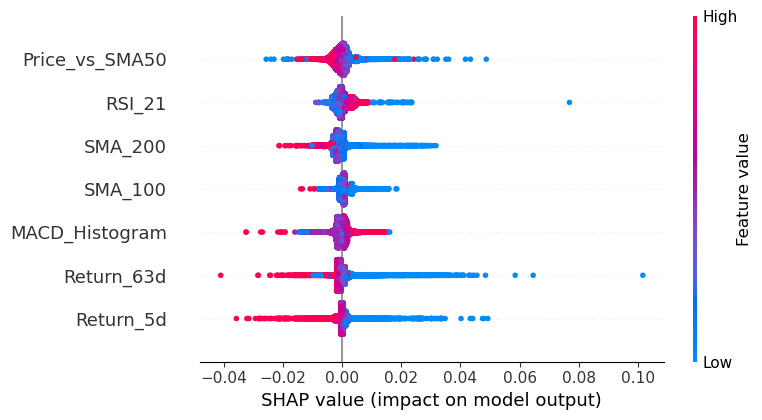

In [28]:
# xgb.plot_importance(model_weekly, max_num_features=10)
# plt.show()

import shap

explainer = shap.TreeExplainer(model_weekly)
shap_values = explainer.shap_values(X_test_simp)
shap.summary_plot(shap_values, X_test_simp)



364395

In [26]:
# print("MSE Monthly: ", mean_squared_error(y_test, y_pred))
print("MSE Weekly Train: ", mean_squared_error(y_train_week, model_weekly.predict(X_train_simp)))
print("MSE Weekly Test: ", mean_squared_error(y_test_week, model_weekly.predict(X_test_simp)))
print("MSE Baseline Test: ", mean_squared_error(y_test_week, np.repeat(np.mean(y_test_week), len(y_test_week))))

MSE Weekly Train:  0.001958647188401012
MSE Weekly Test:  0.0022145499519486606
MSE Baseline Test:  0.002218562824950701


In [19]:
len(test)

128353

0.0023150330424320338

In [18]:
# test['pred_monthly'] = y_pred
# test['error_monthly'] = test['Future_Return_21d'] - test['pred_monthly']
test['pred_weekly'] = y_pred_week
test['error_weekly'] = test['Future_Return_5d'] - test['pred_weekly']


In [19]:
test

,,Close,High,Low,Volume,Future_Return_1d,Future_Return_5d,Future_Return_10d,Future_Return_21d,Future_Return_63d,SMA_5,...,Stoch_K,Stoch_D,Volume_SMA_20,Volume_Ratio,Momentum_10,Momentum_21,Price_vs_SMA20,Price_vs_SMA50,pred_weekly,error_weekly
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
2024-05-01,MMM,95.778595,97.004524,94.649953,11062600.0,-0.016558,-0.021231,0.028444,0.024334,0.293665,91.526740,...,86.778666,73.619914,4745175.0,2.331337,0.082234,0.060319,0.065207,0.131907,0.000720,-0.021951
2024-05-02,MMM,94.192650,95.739667,94.036979,6317100.0,0.003512,0.005371,0.083153,0.037629,0.302653,92.577538,...,69.674656,79.704377,4767820.0,1.324945,0.058264,0.038845,0.044027,0.108035,0.001572,0.003800
2024-05-03,MMM,94.523460,95.535344,94.221836,4818500.0,-0.005764,0.018322,0.083479,0.022078,0.291564,93.612770,...,73.242363,76.565228,4833045.0,0.996991,0.052888,0.073006,0.044247,0.106851,0.001158,0.017164
2024-05-06,MMM,93.978600,95.107241,93.929956,4329500.0,-0.010871,0.031473,0.089243,0.032695,0.301971,94.474815,...,66.808917,69.908646,4864185.0,0.890077,0.042863,0.061079,0.035634,0.095681,0.001404,0.030069
2024-05-07,MMM,92.956993,94.552654,92.937530,4409000.0,0.008478,0.047519,0.079548,0.035191,0.294568,94.286060,...,54.033113,64.694798,4872805.0,0.904818,0.027312,0.039269,0.022770,0.079176,0.001632,0.045887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-29,ZTS,154.912003,155.699378,151.742608,2065100.0,0.006241,-0.035772,0.032040,0.075339,-0.039390,152.625653,...,95.350114,94.835140,3024260.0,0.682845,0.033975,-0.043869,0.025397,-0.021337,-0.002057,-0.033715
2025-04-30,ZTS,155.878769,156.676106,153.257544,2926200.0,-0.004795,-0.002621,-0.009463,0.078197,-0.064722,153.719992,...,94.884141,94.150960,3033820.0,0.964527,0.051654,-0.046901,0.033489,-0.015285,-0.001205,-0.001417
2025-05-01,ZTS,155.131256,156.895361,151.792430,1930300.0,0.011500,0.038805,0.030196,0.088468,-0.049966,154.387756,...,86.485432,92.239896,3028975.0,0.637278,0.064154,-0.035420,0.031020,-0.019950,0.000218,0.038588


In [20]:
cash = 10000
# portfolio = []
for week_no in range(52):
   
    #Make picks
    trade_date = (pd.Timestamp('2024-05-06') + pd.Timedelta(weeks=week_no)).strftime('%Y-%m-%d')
    top_picks = test.loc[idx[:, test.index.get_level_values('Date') == trade_date], :].sort_values('pred_weekly', ascending=False).loc[:,['Close', 'Future_Return_5d', 'pred_weekly', 'error_weekly']].head(10)
    # print(top_picks)
    
    #Create portfolio
    shares_purchased = np.floor((cash/10) / top_picks['Close']) 
    portfolio = shares_purchased * top_picks['Close']
    # print(portfolio)
    
    #Calculate Earnings
    portfolio_amount = sum(portfolio)
    cash_left = cash - portfolio_amount
    new_cash = sum(portfolio * (1 + top_picks['Future_Return_5d'])) + cash_left
    print('Return from Week ', week_no, ': ', new_cash / cash - 1)
    print('Cash remaining: ', new_cash)
    cash = new_cash


Return from Week  0 :  0.019460148239135666
Cash remaining:  10194.601482391357
Return from Week  1 :  0.01998834770419511
Cash remaining:  10398.3747215271
Return from Week  2 :  -0.01263821440466173
Cash remaining:  10266.957832336426
Return from Week  3 :  0.0
Cash remaining:  10266.957832336426
Return from Week  4 :  0.00881508338043635
Cash remaining:  10357.461921691895
Return from Week  5 :  0.0017032532142948753
Cash remaining:  10375.103302001953
Return from Week  6 :  0.0017469021694280773
Cash remaining:  10393.227592468262
Return from Week  7 :  0.0026179975184743576
Cash remaining:  10420.437036514282
Return from Week  8 :  -0.005525603340487573
Cash remaining:  10362.857834815979
Return from Week  9 :  0.04843020538437082
Cash remaining:  10864.733168125153
Return from Week  10 :  0.01613391214079729
Cash remaining:  11040.02381849289
Return from Week  11 :  0.002233902717600822
Cash remaining:  11064.6861577034
Return from Week  12 :  -0.03028516941533299
Cash remaining:

In [ ]:

most_recent_date = max(dataframe.index.get_level_values('Date'))
X_now = dataframe.loc[idx[:, dataframe.index.get_level_values('Date') == most_recent_date], :].drop(['Future_Return_1d', 'Future_Return_5d', 'Future_Return_10d', 'Future_Return_21d', 'Future_Return_63d'], axis=1).dropna()
X_now['weekly_predict'] = model_weekly.predict(X_now)
top_picks = X_now.sort_values('weekly_predict', ascending=False).loc[:,['Close', 'High', 'Low', 'Volume', 'weekly_predict']].head(10)
print(top_picks)
print(np.floor((cash/10) / top_picks['Close']) )


                         Close         High          Low      Volume  \
Date       Ticker                                                      
2025-08-01 LW        55.990002    56.820000    55.500000   1668700.0   
           MOH      155.130005   160.490005   153.009995   2007200.0   
           ALGN     136.520004   139.000000   129.000000   7974600.0   
           RCL      314.250000   315.750000   303.989990   2827600.0   
           FICO    1381.069946  1430.209961  1350.000000    798500.0   
           DOW       21.790001    23.080000    21.790001  25041700.0   
           BAX       21.959999    22.360001    21.330000  22646900.0   
           WBD       12.870000    13.060000    12.570000  59355700.0   
           CZR       25.680000    26.565001    25.465000   7822700.0   
           FCX       40.029999    40.180000    39.279999  15584500.0   

                   weekly_predict  
Date       Ticker                  
2025-08-01 LW            0.081176  
           MOH           0.

In [215]:
list(X_now)

['Close',
 'High',
 'Low',
 'Volume',
 'SMA_5',
 'EMA_5',
 'SMA_10',
 'EMA_10',
 'SMA_20',
 'EMA_20',
 'SMA_50',
 'EMA_50',
 'SMA_100',
 'EMA_100',
 'SMA_200',
 'EMA_200',
 'Return_1d',
 'Return_5d',
 'Return_10d',
 'Return_21d',
 'Return_63d',
 'Volatility_10d',
 'Volatility_21d',
 'Volatility_63d',
 'RSI_14',
 'RSI_21',
 'MACD',
 'MACD_Signal',
 'MACD_Histogram',
 'BB_Upper',
 'BB_Middle',
 'BB_Lower',
 'BB_Width',
 'BB_Position',
 'ATR_14',
 'Stoch_K',
 'Stoch_D',
 'Volume_SMA_20',
 'Volume_Ratio',
 'Momentum_10',
 'Momentum_21',
 'Price_vs_SMA20',
 'Price_vs_SMA50',
 'weekly_predict']